In [69]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gpflow
from graph_matern.kernels.graph_matern_kernel import GraphMaternKernel
from graph_matern.kernels.graph_diffusion_kernel import GraphDiffusionKernel
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from node2vec import Node2Vec
import random

In [231]:
# Data processing
input_file = "uk-2007-05.hostgraph_weighted.graph-txt"  
output_file = "edge_list.csv"  

with open(input_file, "r") as infile, open(output_file, "w") as outfile:
    outfile.write("source target weight\n")
    num_hosts = int(infile.readline().strip()) 
    source_host = 0  # Initialize source host
    # Process each line for the out-links
    for line in infile:
        line = line.strip()
        if line: 
            # Each line is "dest1:nlinks1 dest2:nlinks2 ..."
            links = line.split()
            for link in links:
                dest, weight = map(int, link.split(":"))
                outfile.write(f"{source_host} {dest} {weight}\n")
        source_host += 1

label = {}
for input_file in ["WEBSPAM-UK2007-SET1-labels.txt","WEBSPAM-UK2007-SET2-labels.txt"]:
    with open(input_file, "r") as infile:
        for line in infile:
            line = line.strip()
            if line: 
                # Each line is "node index, label, ..."
                labels = line.split()
                label[labels[0]]=labels[1]

input_file = "WEBSPAM-UK2007-hostnames.txt" 
output_file = "node_list.csv"  
with open(input_file, "r") as infile, open(output_file, "w") as outfile:
    outfile.write("id isspam url\n")
    for line in infile:
        line = line.strip()
        if line: 
            # Each line is "node index, url"
            data = line.split()
            lab = label[data[0]] if data[0] in label.keys() else 'inaccessible'
            outfile.write(f"{data[0]} {lab} {data[1]}\n")

# considering the running time issue, we take a subgraph


# Load the node and edge lists
node_list = pd.read_csv("node_list.csv",sep=" ")
edge_list = pd.read_csv("edge_list.csv",sep=" ")
accessible_nodes = node_list[node_list['isspam'] != 'inaccessible']
inaccessible_nodes = node_list[node_list['isspam'] == 'inaccessible']

# Select up to 10,000 nodes: all accessible nodes first, then add inaccessible nodes
accessible_count = len(accessible_nodes)
nodes_needed = 10000 - accessible_count
if nodes_needed > 0:
    selected_inaccessible_nodes = inaccessible_nodes.head(nodes_needed)
else:
    selected_inaccessible_nodes = pd.DataFrame(columns=node_list.columns)

sub_nodes = pd.concat([accessible_nodes, selected_inaccessible_nodes]).head(10000)
# Filter the edge list to include only edges where both ends are in the subgraph
sub_node_ids = set(sub_nodes['id'])
sub_edges = edge_list[edge_list['source'].isin(sub_node_ids) & edge_list['target'].isin(sub_node_ids)]
sub_edge_ids=set(sub_edges['source']).union(set(sub_edges['target']))
sub_nodes = sub_nodes[sub_nodes['id'].isin(sub_edge_ids)]
# Save the results
node_list=sub_nodes.sort_values(by='id')
edge_list=sub_edges
node_list.to_csv("sub_node_list.csv", index=False)
edge_list.to_csv("sub_edge_list.csv", index=False)

G = nx.DiGraph()
inv_G = nx.DiGraph()
for _, row in edge_list.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'])
    inv_G.add_edge(row['target'], row['source'], weight=row['weight'])
inv_score = nx.pagerank(G, alpha=0.85, weight='weight')
sorted_inv_pagerank = sorted(inv_score.items(), key=lambda x: x[1], reverse=True)
for _, row in node_list.iterrows():
    G.nodes[row['id']]['isspam'] = row['isspam']
    G.nodes[row['id']]['url'] = row['url']
    G.nodes[row['id']]['seedset'] = 1/2

seedset=node_list[node_list['id'].isin([x[0] for x in sorted_inv_pagerank[:100]])]
goodset=list(set(seedset[seedset['isspam']=='nonspam']['id']))
badset=list(set(seedset[seedset['isspam']=='spam']['id']))
for _, row in node_list.iterrows():
    idt=row['id']
    if idt in goodset:
        G.nodes[row['id']]['seedset'] = 1
    if idt in badset:
        G.nodes[row['id']]['seedset'] = 0   



# raw_pagerank_result= sorted(raw_pagerank_result.items(), key=lambda x: x[1], reverse=True)

In [328]:
def normalize_adjacency_matrix(graph):
    """
    Normalize adjacency matrix to convert it into a transition probability matrix.
    """
    adjacency_matrix = nx.to_numpy_array(graph,weight="weight")
    row_sums = adjacency_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Prevent division by zero for isolated nodes
    return adjacency_matrix / row_sums

def trustrank(graph, attr='seedset', alpha=0.85, max_iter=100, tol=1e-6, trunc=False):
    transition_matrix = normalize_adjacency_matrix(graph)
    initial=np.array(list(nx.get_node_attributes(graph,attr).values()))
    # Initialize teleportation vector
    n = len(graph.nodes)
    teleport = np.zeros(n)
    seed_nodes=np.where(abs(initial - 0.5)>0.1)[0]
    for seed in seed_nodes:
        teleport[seed] = 1 / len(seed_nodes)
    # Initialize scores
    if trunc:
        for i in range(len(initial)):
            if initial[i]<0.4:
                initial[i]=0
            elif initial[i]>0.6:
                initial[i]=1
            else:
                initial[i]=0.5
    scores = initial / np.sum(initial)  # Uniform initial distribution
    
    for iteration in range(max_iter):
        new_scores = alpha * np.dot(transition_matrix.T, scores) + (1 - alpha) * teleport
        if np.linalg.norm(new_scores - scores, ord=1) < tol:
            break
        scores = new_scores
    
    rst={node: score for node, score in zip(graph.nodes, scores)}
    # rst=sorted(rst.items(), key=lambda x: x[1], reverse=True)
    return rst

    
raw_trustrank_result=trustrank(G)
raw_pagerank_result= nx.pagerank(G, alpha=0.85)

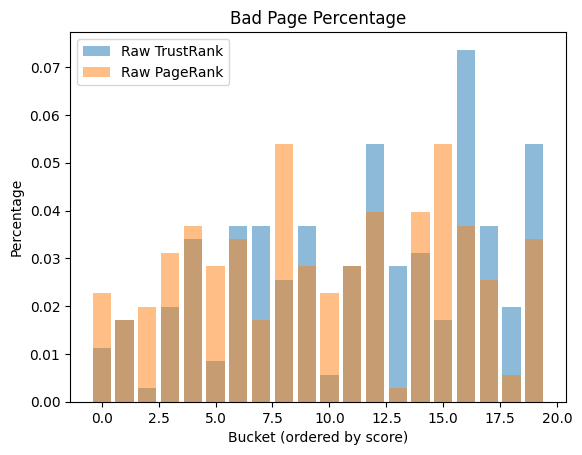

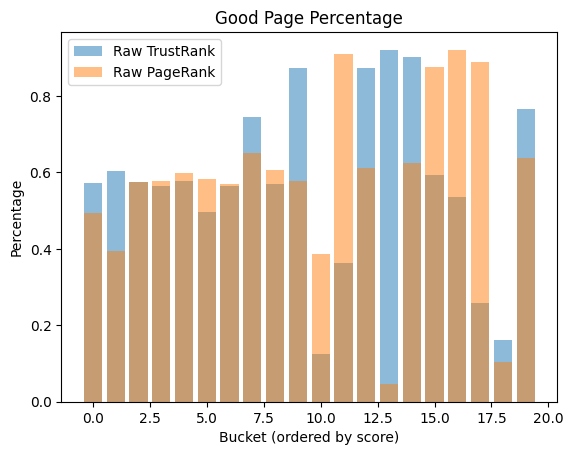

In [329]:
def make_bucket_plot(rst,isspam,graph=G,label="",main="",bar=True):
    sorted_rst=dict(sorted(rst.items(), key=lambda x: x[1], reverse=True))
    n=int(len(rst)/20)
    spam=[]
    nonspam=[]
    for i in range(20):
        temp_rst=list(sorted_rst.keys())[i*n:(i+1)*n]
        temp=np.array([graph.nodes[node]["isspam"] for node in temp_rst])
        spam.append(np.mean(np.array(temp=='spam')))
        nonspam.append(np.mean(np.array(temp=='nonspam')))
    if bar:
        if isspam:
            plt.bar(range(20),spam,alpha=0.5,label=label)
        else:
            plt.bar(range(20),nonspam,alpha=0.5,label=label)
    else:
        if isspam:
            plt.plot(range(20),spam,alpha=0.5)
            plt.scatter(range(20),spam,alpha=0.5,label=label)
        else:
            plt.plot(range(20),nonspam,alpha=0.5)
            plt.scatter(range(20),nonspam,alpha=0.5,label=label)
    plt.xlabel('Bucket (ordered by score)')
    plt.ylabel('Percentage')
    plt.title(main)
    plt.legend()
make_bucket_plot(raw_trustrank_result,isspam=True,label="Raw TrustRank",main="Bad Page Percentage")
make_bucket_plot(raw_pagerank_result,isspam=True,label="Raw PageRank",main="Bad Page Percentage")
plt.show()
make_bucket_plot(raw_trustrank_result,isspam=False,label="Raw TrustRank",main="Good Page Percentage")
make_bucket_plot(raw_pagerank_result,isspam=False,label="Raw PageRank",main="Good Page Percentage")
plt.show()

In [19]:
node2vec = Node2Vec(
    G,
    dimensions=64,  # Size of embedding
    walk_length=10,  # Length of each random walk
    num_walks=50,   # Number of walks per node
    workers=4        # Number of parallel workers
)

# Train the Node2Vec model to generate embeddings
model = node2vec.fit(window=10, min_count=1, batch_words=4)
node_embeddings = np.array([model.wv[str(node)] for node in G.nodes()])

Computing transition probabilities: 100%|██████████| 7075/7075 [00:03<00:00, 2357.69it/s]


In [223]:
mapping = {old_label: new_label for new_label, old_label in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)
selected_nodes = random.sample(list(G.nodes), 1000)
sub_G = G.subgraph(selected_nodes).copy()
laplacian = nx.laplacian_matrix(sub_G.to_undirected()).toarray().astype('float64') # G is a networkx Graph
eigenvalues, eigenvectors = tf.linalg.eigh(laplacian)  # only should be done once-per-graph


In [224]:
dtype = tf.float64
x_train=node_embeddings[selected_nodes]
y_train=np.array(list(nx.get_node_attributes(sub_G,"seedset").values()))
if y_train.ndim == 1:
    y_train = y_train.reshape(-1, 1)
x_train = tf.convert_to_tensor(x_train, dtype=tf.float64)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float64)    
N = len(sub_G)
vertex_dim = x_train.shape[1]-1
point_kernel = gpflow.kernels.Matern32()
kernel = GraphMaternKernel((eigenvectors, eigenvalues), 
                           nu=3.0/2, 
                           kappa=5.0, 
                           sigma_f=1.0, 
                           vertex_dim=vertex_dim, 
                           point_kernel=point_kernel, 
                           dtype=dtype,
                           )

In [225]:
model = gpflow.models.GPR(data=(x_train, y_train), kernel=kernel, noise_variance=0.01)
adam = tf.optimizers.Adam(learning_rate=0.01)

@tf.function
def training_step():
    with tf.GradientTape() as tape:
        loss = model.training_loss()
    gradients = tape.gradient(loss, model.trainable_variables)
    adam.apply_gradients(zip(gradients, model.trainable_variables))

# Train the model
for step in range(100):  # Number of optimization steps
    training_step()

# Print the summary after training
gpflow.utilities.print_summary(model)

╒══════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                                 │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞══════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.point_kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.487725   │
├──────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.point_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.71523    │
├──────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.nu                        │ Parameter │ Softplus         │         │ True        │ (

In [226]:
mean, cov = model.predict_f(x_train, full_cov=True)
mapping = {old_label: new_label for new_label, old_label in enumerate(sub_G.nodes())}
sub_G = nx.relabel_nodes(sub_G, mapping)
for node in sub_G.nodes():
    sub_G.nodes[node]['GPG']=np.array(mean).flatten()[node]

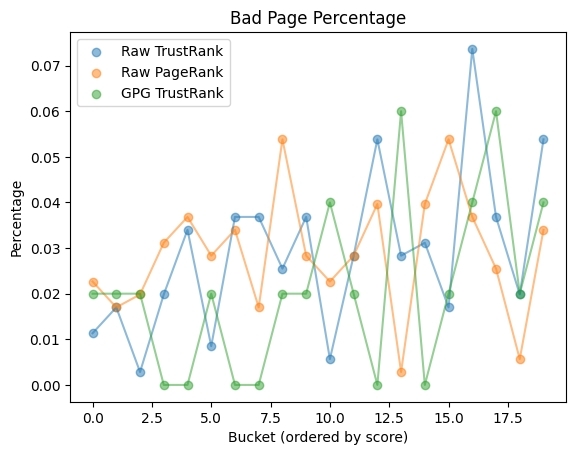

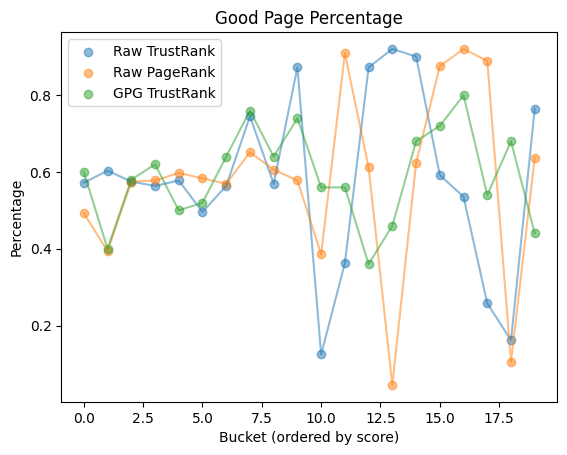

In [237]:
GPG_trustrank_result=trustrank(sub_G,attr='GPG',max_iter=1)
make_bucket_plot(raw_trustrank_result,isspam=True,label="Raw TrustRank",main="Bad Page Percentage",bar=False)
make_bucket_plot(raw_pagerank_result,isspam=True,label="Raw PageRank",main="Bad Page Percentage",bar=False)
make_bucket_plot(GPG_trustrank_result,isspam=True,graph=sub_G,label="GPG TrustRank",main="Bad Page Percentage",bar=False)
plt.show()
make_bucket_plot(raw_trustrank_result,isspam=False,label="Raw TrustRank",main="Good Page Percentage",bar=False)
make_bucket_plot(raw_pagerank_result,isspam=False,label="Raw PageRank",main="Good Page Percentage",bar=False)
make_bucket_plot(GPG_trustrank_result,isspam=False,graph=sub_G,label="GPG TrustRank",main="Good Page Percentage",bar=False)
plt.show()

In [274]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx
from torch_geometric.loader import DataLoader

In [320]:
mapping = {old_label: new_label for new_label, old_label in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)
x_train=node_embeddings
y_train=np.array(list(nx.get_node_attributes(G,"seedset").values()))

data = from_networkx(G)
data.x = torch.tensor(x_train, dtype=torch.float)
data.y = torch.tensor(y_train, dtype=torch.float)
data.train_mask = torch.arange(1000) 

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, data):
        # Extract node features (x) and edge indices (edge_index) from the data object
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


# Model parameters
in_channels = x_train.shape[1]  # Input feature size (64)
hidden_channels = 128           # Hidden layer size
out_channels = 1  # Number of classes or regression output size

# Create the model, optimizer, and loss function
model = GraphSAGE(in_channels, hidden_channels, out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()   # For classification

# Training loop
model.train()
for epoch in range(200):  # Number of epochs
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute loss
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

d:\py311\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.5920605659484863
Epoch 10, Loss: 0.04594177007675171
Epoch 20, Loss: 0.02239142172038555
Epoch 30, Loss: 0.01714998297393322
Epoch 40, Loss: 0.01324645895510912
Epoch 50, Loss: 0.011672435328364372
Epoch 60, Loss: 0.011105448007583618
Epoch 70, Loss: 0.010655502788722515
Epoch 80, Loss: 0.010352651588618755
Epoch 90, Loss: 0.01013608556240797
Epoch 100, Loss: 0.009974935092031956
Epoch 110, Loss: 0.009853748604655266
Epoch 120, Loss: 0.009763631038367748
Epoch 130, Loss: 0.009687241166830063
Epoch 140, Loss: 0.009623316116631031
Epoch 150, Loss: 0.009589229710400105
Epoch 160, Loss: 0.00951863918453455
Epoch 170, Loss: 0.00946238823235035
Epoch 180, Loss: 0.00942331925034523
Epoch 190, Loss: 0.009388451464474201


In [358]:
model.eval()
out = model(data)  
GNN_init={i:float(out.flatten()[i]) for i in range(len(G))}
for node in sub_G.nodes():
    sub_G.nodes[node]['GNN']=GNN_init[node]
GNN_trustrank_result=trustrank(sub_G,attr='GNN',trunc=True)

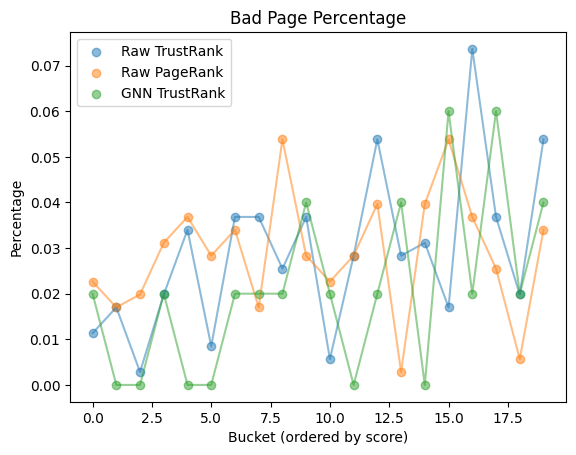

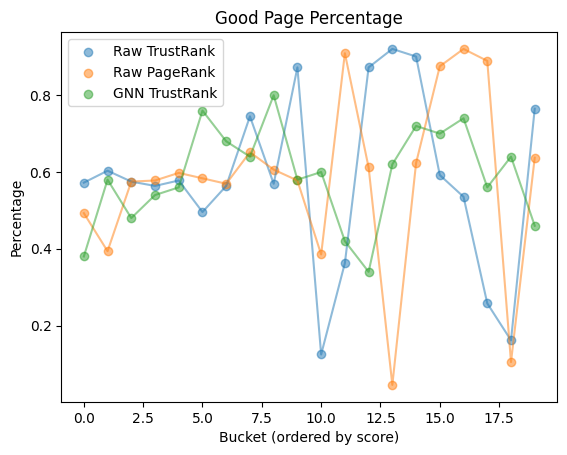

In [362]:
GPG_trustrank_result=trustrank(sub_G,attr='GPG',max_iter=1)
make_bucket_plot(raw_trustrank_result,isspam=True,label="Raw TrustRank",main="Bad Page Percentage",bar=False)
make_bucket_plot(raw_pagerank_result,isspam=True,label="Raw PageRank",main="Bad Page Percentage",bar=False)
make_bucket_plot(GNN_trustrank_result,isspam=True,graph=sub_G,label="GNN TrustRank",main="Bad Page Percentage",bar=False)
plt.show()
make_bucket_plot(raw_trustrank_result,isspam=False,label="Raw TrustRank",main="Good Page Percentage",bar=False)
make_bucket_plot(raw_pagerank_result,isspam=False,label="Raw PageRank",main="Good Page Percentage",bar=False)
make_bucket_plot(GNN_trustrank_result,isspam=False,graph=sub_G,label="GNN TrustRank",main="Good Page Percentage",bar=False)
plt.show()